In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from wrf import vinterp, to_np, getvar, CoordPair, vertcross, get_cartopy, latlon_coords


C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
# Input variables as integers
year = 2019
month = 2
start_day = 25
start_hour = 0
end_day = 25
end_hour = 23

# Format the integers into the desired string format
year_month = f'{year}{month:02d}'  # yyyymm
start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
    'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
    'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',
    'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
    'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc',
    'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc'  # PV URL
}

# Initialize an empty dictionary to store the datasets
datasets = {}

# Try to load datasets from the URLs
for var, url in urls.items():
    try:
        tds_catalog = TDSCatalog(url)
        ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
        ds = xr.open_dataset(ds_url).metpy.parse_cf()
        datasets[var] = ds
        print(f"Successfully loaded {var}")

    except Exception as e:
        print(f"Error loading {var}: {e}")

# Merge all pressure level datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['pv_pl']])
    print("Successfully merged pressure level datasets")

except KeyError as e:
    print(f"Error merging pressure level datasets: {e}")

# Merge all surface datasets into a single Xarray Dataset if they were successfully loaded
try:
    ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])
    print("Successfully merged surface datasets")
    
except KeyError as e:
    print(f"Error merging surface datasets: {e}")

try:
    # Get the first and last times from the pressure level dataset to slice the surface dataset
    first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values

    # Slice the surface dataset to keep only the times from the first to the last time in ds_pl
    ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))

except KeyError as e:
    print(f"Error accessing 'time' in the datasets: {e}")

except Exception as e:
    print(f"An error occurred during slicing: {e}")


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl
Successfully merged pressure level datasets
Successfully merged surface datasets


In [24]:
def theta_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg

        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')
        t = ds_cross['T'].sel(level=slice(150, 1000)) # units: K
        pressure_levels = t['level'] # units: hPa
        theta = mpcalc.potential_temperature(pressure_levels, t) # units: K
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV and $\\theta$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)

    
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()

def thetae_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg

        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')
        t = ds_cross['T'].sel(level=slice(150, 1000)) # units: K
        q = ds_cross['Q'].sel(level=slice(150, 1000)) # units: kg/
        pressure_levels = t['level'] # units: hPa
        # Calculate the dewpoint and equivalent potential temperature
        td = mpcalc.dewpoint_from_specific_humidity(pressure_levels, t, q)
        theta_e = mpcalc.equivalent_potential_temperature(pressure_levels, t, td) # units: K

        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        thetae_smoothed = gaussian_filter(theta_e, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, thetae_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta_e$ Equivalent Potential Temperature (K)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV and $\\theta_e$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)

    
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()

def fgen_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g):
       # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg
        pressure_levels = q_sliced.level * 100 # units: Pa

        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')
        t = ds_cross['T'].sel(level=slice(150, 1000)) # units: K
        q = ds_cross['Q'].sel(level=slice(150, 1000)) # units: kg/kg
        u = ds_cross['U'].sel(level=slice(150, 1000)) # units: m/s
        v = ds_cross['V'].sel(level=slice(150, 1000))
        pressure_levels = t['level'] # units: hPa

        # Calculate the dewpoint and equivalent potential temperature
        theta = mpcalc.potential_temperature(pressure_levels, t) # units: K
        fgen = mpcalc.frontogenesis(theta, u, v, pressure_levels) # units: K / m / s
        fgen_3hr = fgen * 1.08e9 # units: K / 100km / hr

        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        thetae_smoothed = gaussian_filter(theta_e, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, thetae_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        fgen_c = ax.contour(ds_cross['longitude'], pressure_levels, fgen_3hr, colors='black', levels=np.arange(-10, 10, 1), linestyles='dashed')
        ax.clabel(fgen_c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta_e$ Equivalent Potential Temperature (K)')
        fgen_line = plt.Line2D([0], [0], color='black', linewidth=1, linestyle='dashed', label='Frontogenesis (K / 100km / hr)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV, FGEN, and $\\theta_e$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)

    
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()

def updated_cross(start_point, end_point, ds_pl, ds_sfc, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Get the u, v, t, and q fields at multiple levels
        u_sliced = ds_pl_sliced['U'].sel(level=slice(150, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(150, 1000)) # units: m/s
        t_sliced = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(150, 1000)) # units: kg/kg
        pressure_levels = t_sliced['level'] # units: 
        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate potential temperature
        theta = mpcalc.potential_temperature(pressure_levels, t_sliced) # units: K

        # Calculate frontogenesis
        #fgen = mpcalc.frontogenesis(theta, u_sliced, v_sliced, pressure_levels) # units: K / m / s
        #fgen_3hr = fgen * 1.08e9 # units: K / 100km / hr

        # Add the potential temperature (theta) to the dataset
        theta_da = xr.DataArray(theta, dims=['level', 'latitude', 'longitude'],
                                coords={'level': t_sliced['level'], 
                                        'latitude': t_sliced['latitude'], 
                                        'longitude': t_sliced['longitude']},
                                attrs={'units': 'K'})

        ds_pl_sliced['THETA'] = theta_da

        # Add the frontogenesis field to the dataset with the same structure
        #fgen_da = xr.DataArray(fgen_3hr, dims=['level', 'latitude', 'longitude'],
        #                    coords={'level': t_sliced['level'], 
        #                            'latitude': t_sliced['latitude'], 
        #                            'longitude': t_sliced['longitude']},
        #                    attrs={'units': 'K / 100km / hr'})

        # Add fgen to the original dataset as a new variable
        #ds_pl_sliced['FGEN'] = fgen_da

                # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 


        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Now do the cross-section interpolation
        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        
        # Interpolate the sliced data for the cross-section
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')

        # Get the temperature, potential vorticity, and theta 
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K
        theta_crossed = ds_cross['THETA'].sel(level=slice(150, 1000)) # units: K
        #fgen_crossed = ds_cross['FGEN'].sel(level=slice(150, 1000)) # units: K / 100km / hr

        # Get the pressure levels
        pressure_levels = pv_crossed['level'] # units: hPa

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta_crossed, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        #fgen_c = ax.contour(ds_cross['longitude'], pressure_levels, fgen_3hr, colors='black', levels=np.arange(-10, 10, 1), linestyles='dashed')
        #ax.clabel(fgen_c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')
        #fgen_line = plt.Line2D([0], [0], color='black', linewidth=1, linestyle='dashed', label='Frontogenesis (K / 100km / hr)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude (degrees E)')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV, FGEN, and $\\theta$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)

    
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()

def updated_cross(start_point, end_point, ds_pl, ds_sfc, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Get the u, v, t, and q fields at multiple levels
        u_sliced = ds_pl_sliced['U'].sel(level=slice(150, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(150, 1000)) # units: m/s
        t_sliced = ds_pl_sliced['T'].sel(level=slice(150, 1000)) # units: K
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(150, 1000)) # units: kg/kg
        pressure_levels = t_sliced['level'] # units: 
        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate potential temperature
        theta = mpcalc.potential_temperature(pressure_levels, t_sliced) # units: K

        # Calculate frontogenesis
        #fgen = mpcalc.frontogenesis(theta, u_sliced, v_sliced, pressure_levels) # units: K / m / s
        #fgen_3hr = fgen * 1.08e9 # units: K / 100km / hr

        # Add the potential temperature (theta) to the dataset
        theta_da = xr.DataArray(theta, dims=['level', 'latitude', 'longitude'],
                                coords={'level': t_sliced['level'], 
                                        'latitude': t_sliced['latitude'], 
                                        'longitude': t_sliced['longitude']},
                                attrs={'units': 'K'})

        ds_pl_sliced['THETA'] = theta_da

        # Add the frontogenesis field to the dataset with the same structure
        #fgen_da = xr.DataArray(fgen_3hr, dims=['level', 'latitude', 'longitude'],
        #                    coords={'level': t_sliced['level'], 
        #                            'latitude': t_sliced['latitude'], 
        #                            'longitude': t_sliced['longitude']},
        #                    attrs={'units': 'K / 100km / hr'})

        # Add fgen to the original dataset as a new variable
        #ds_pl_sliced['FGEN'] = fgen_da

                # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 


        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Now do the cross-section interpolation
        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        
        # Interpolate the sliced data for the cross-section
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')

        # Get the temperature, potential vorticity, and theta 
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K
        theta_crossed = ds_cross['THETA'].sel(level=slice(150, 1000)) # units: K
        #fgen_crossed = ds_cross['FGEN'].sel(level=slice(150, 1000)) # units: K / 100km / hr

        # Get the pressure levels
        pressure_levels = pv_crossed['level'] # units: hPa

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta_crossed, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        #fgen_c = ax.contour(ds_cross['longitude'], pressure_levels, fgen_3hr, colors='black', levels=np.arange(-10, 10, 1), linestyles='dashed')
        #ax.clabel(fgen_c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')
        #fgen_line = plt.Line2D([0], [0], color='black', linewidth=1, linestyle='dashed', label='Frontogenesis (K / 100km / hr)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude (degrees E)')
        plt.ylabel('Pressure (hPa)')
        plt.title(f'ERA5 Reanalysis Vertical Cross-Section of PV and $\\theta$ | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)
        #isobars = ax_inset.contour(mslp['longitude'], mslp['latitude'], gaussian_filter(mslp, sigma=1), colors='black', levels=np.arange(960, 1040, 4), linewidths=0.25)
        #plt.clabel(isobars, inline=True, inline_spacing=5, fontsize=6, fmt='%i')
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')



        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()


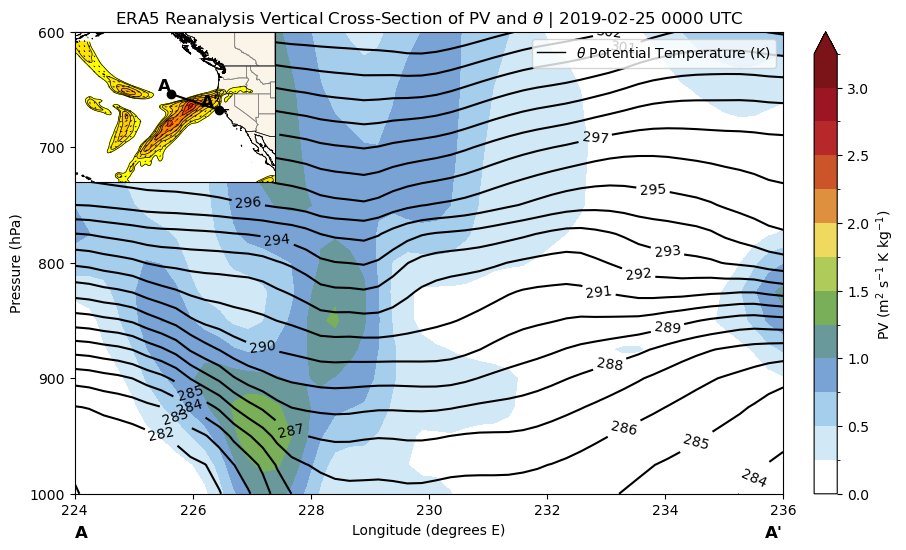

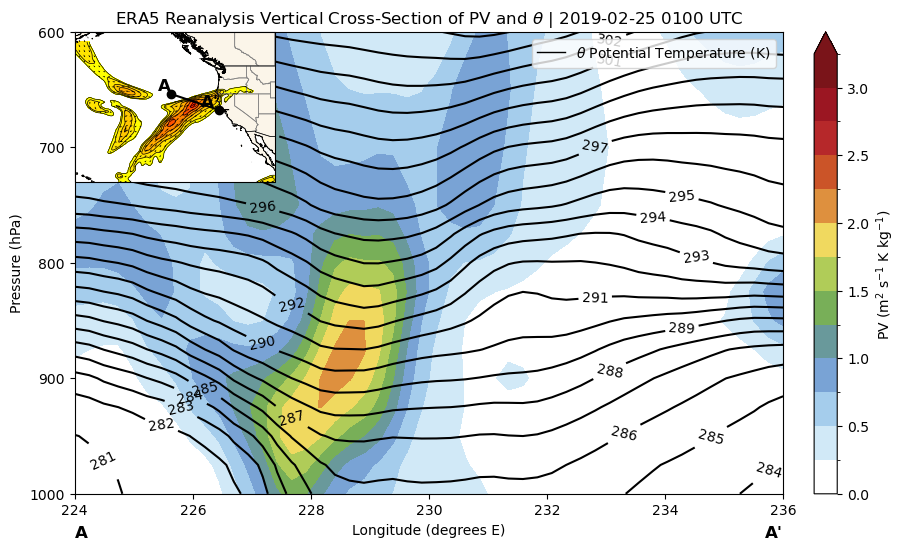

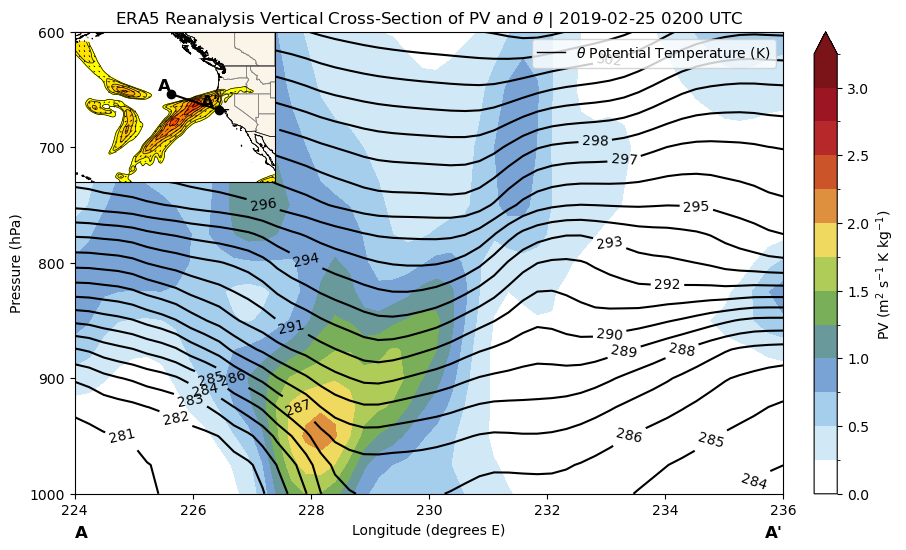

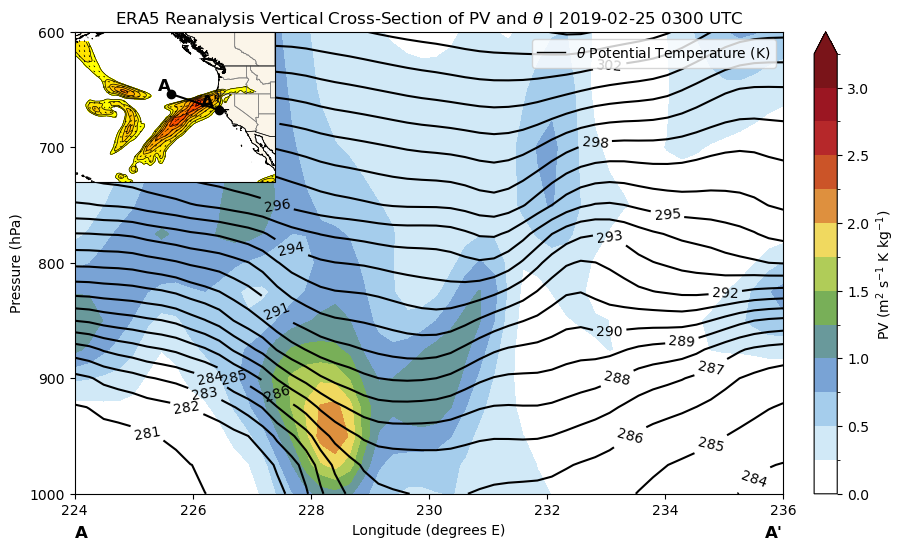

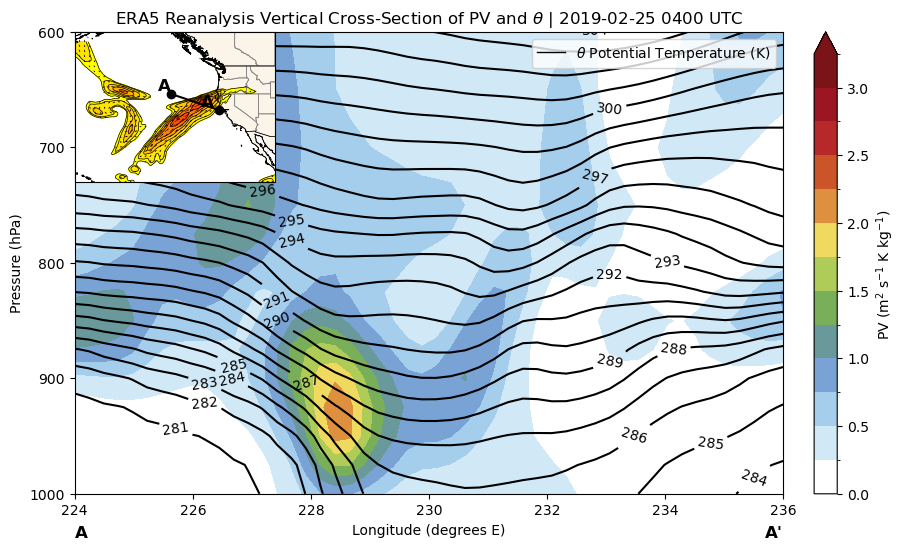

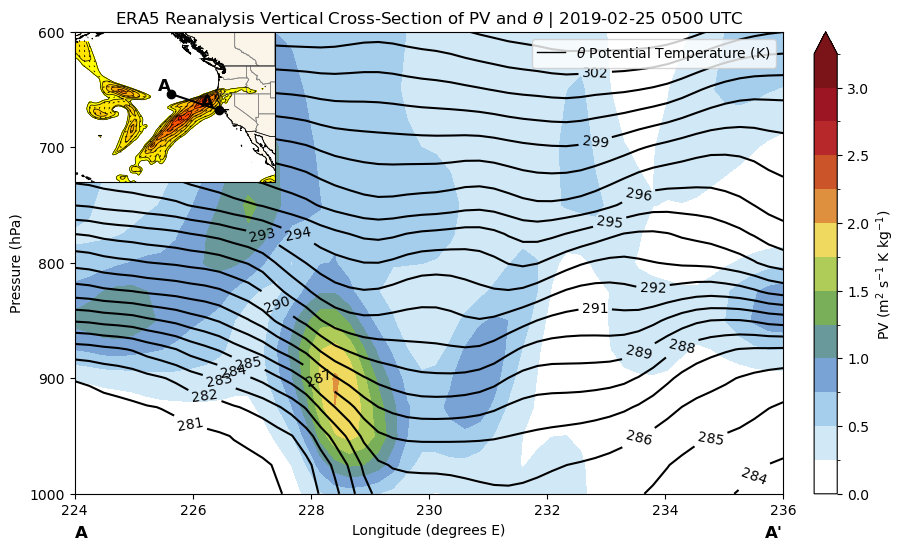

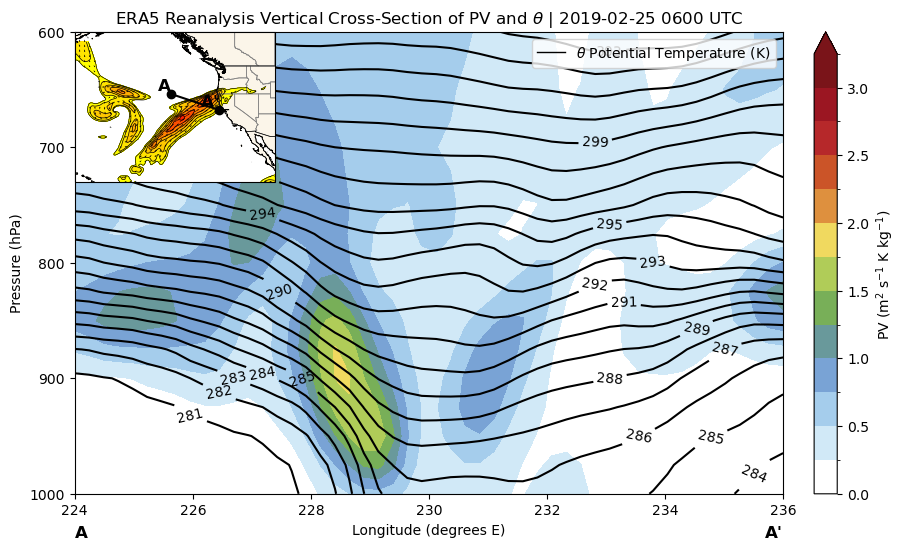

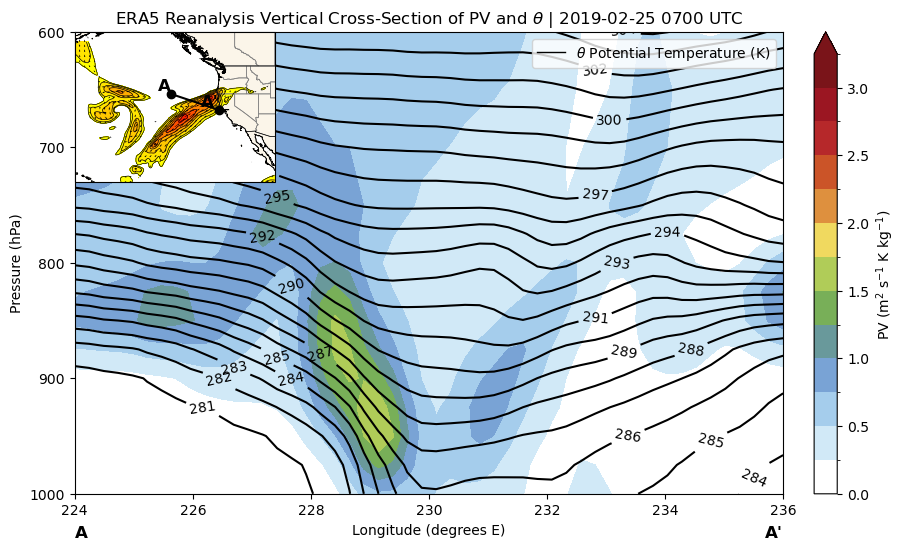

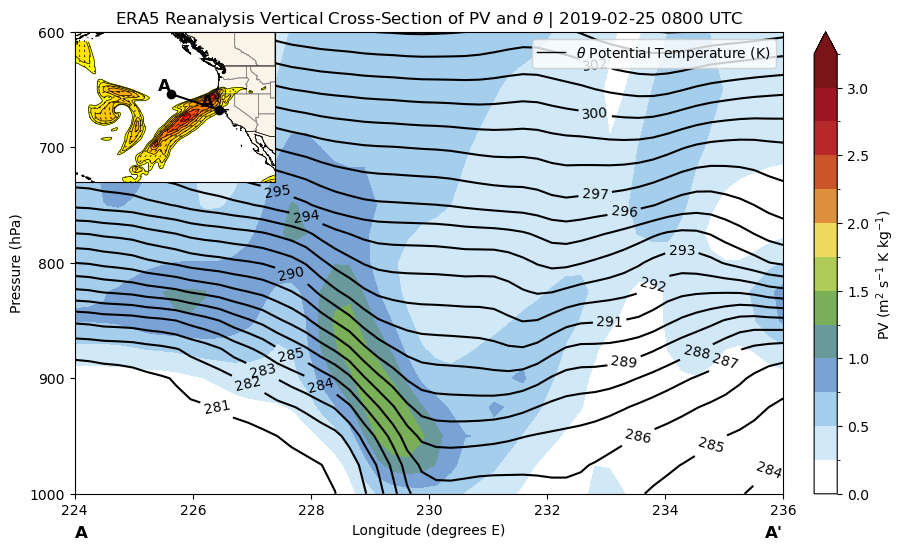

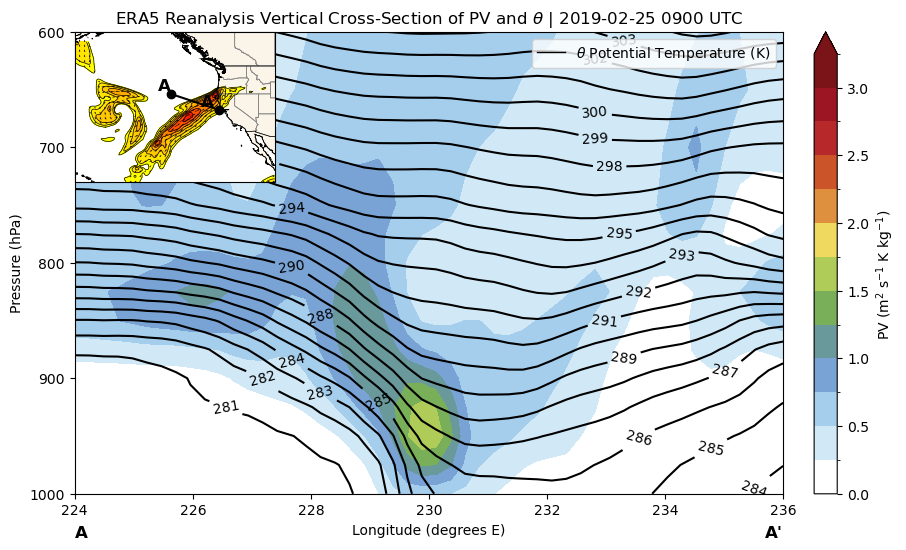

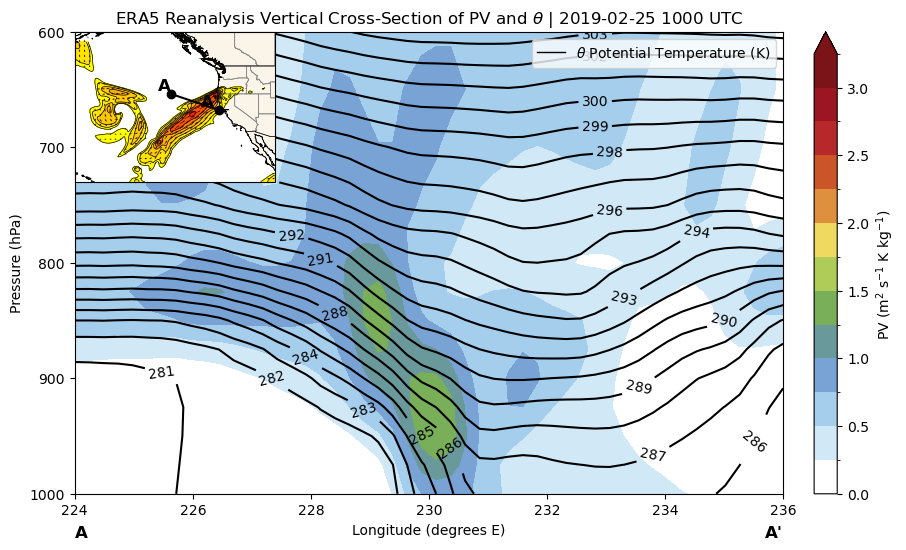

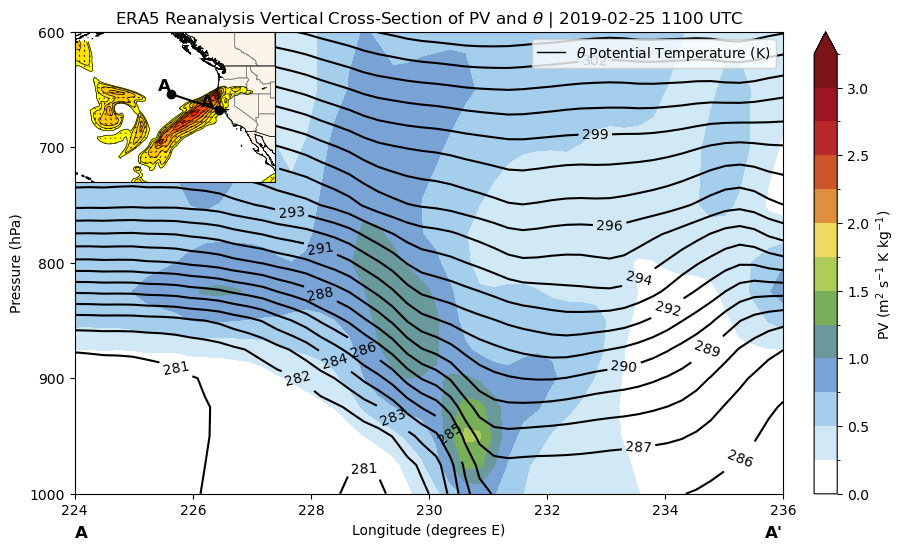

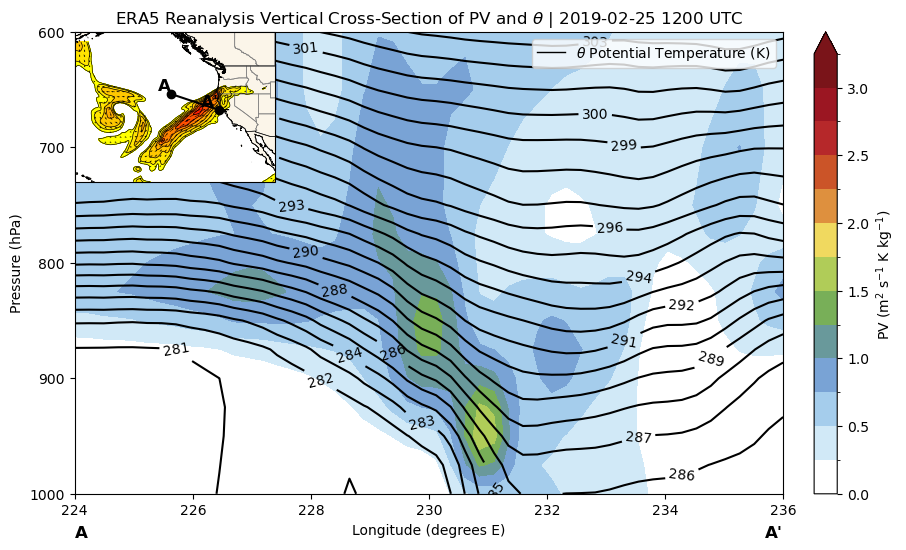

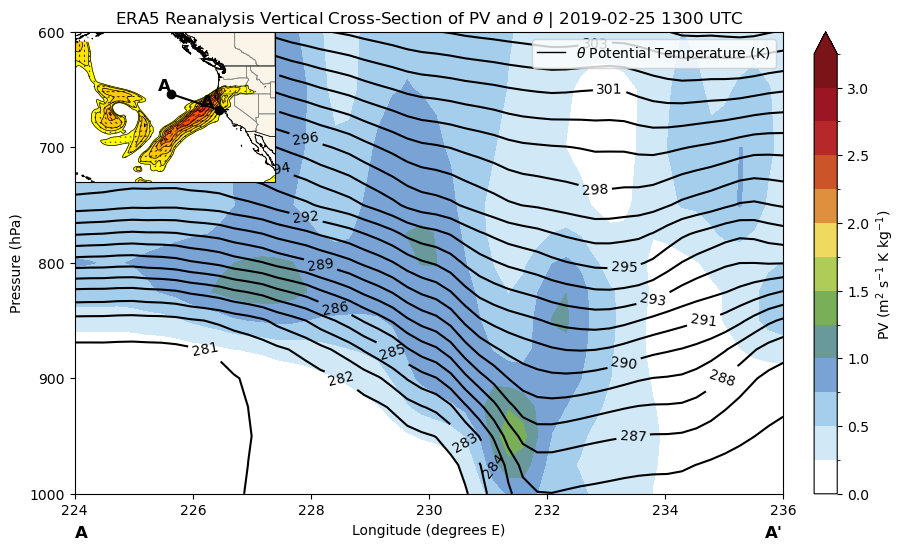

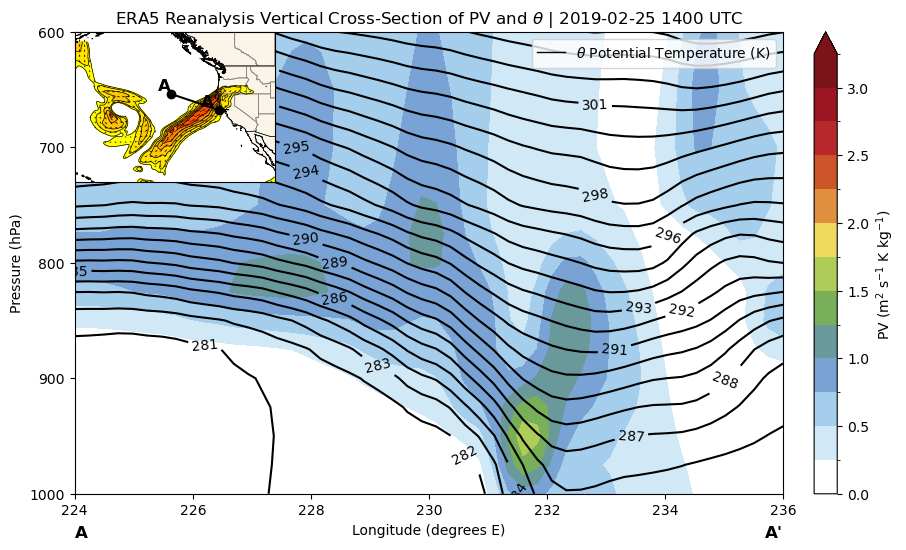

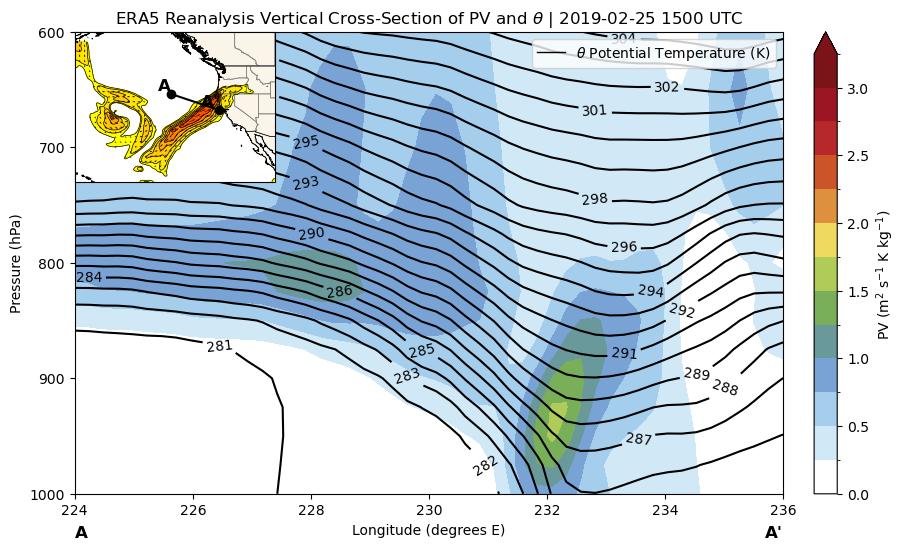

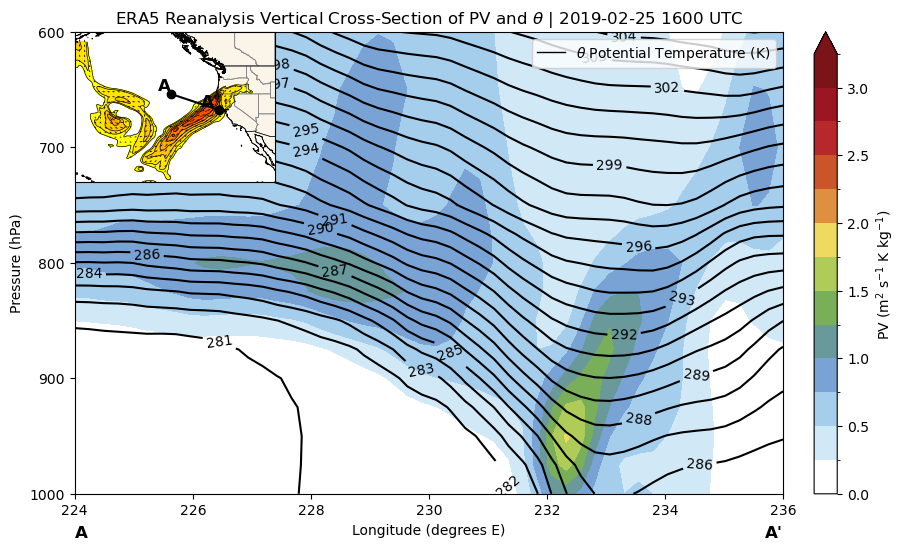

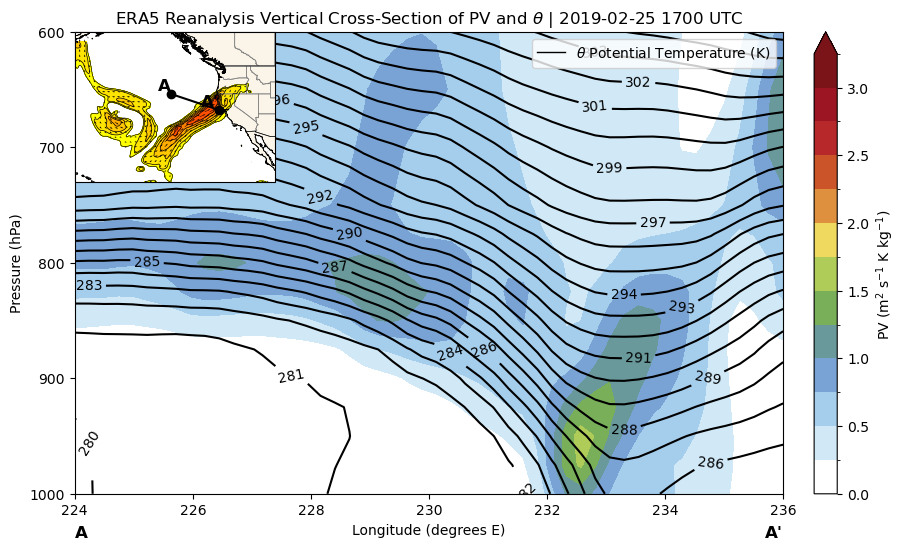

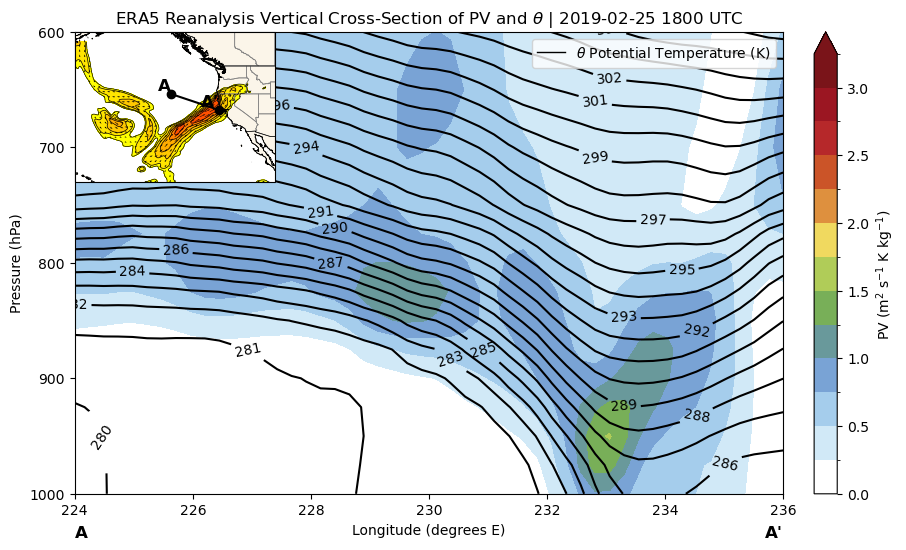

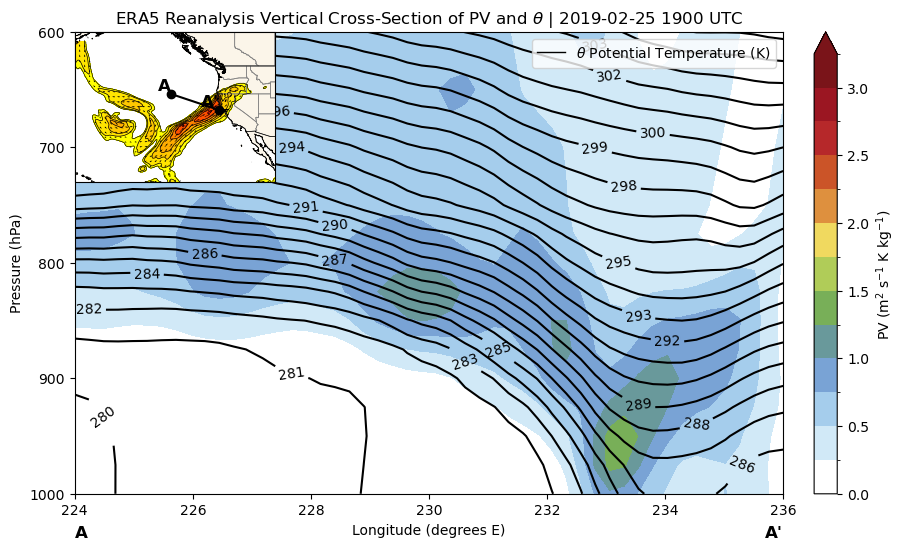

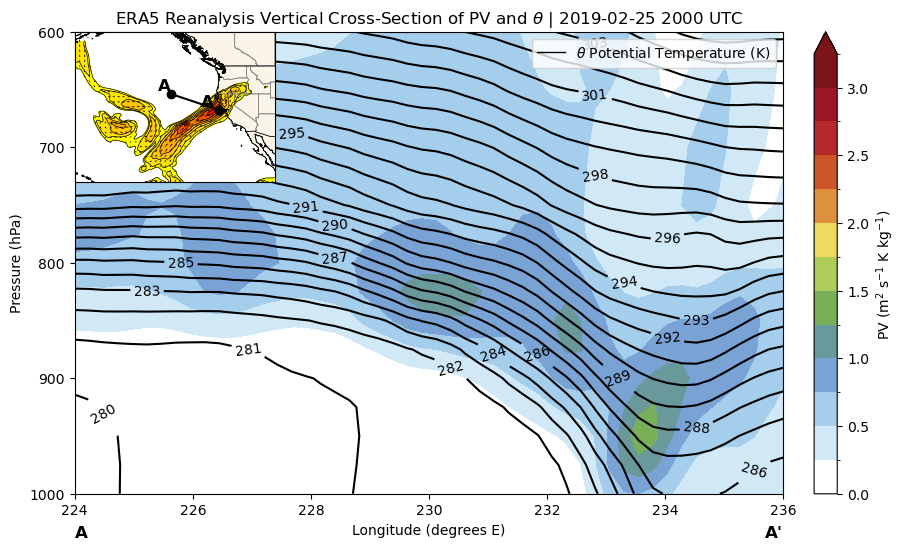

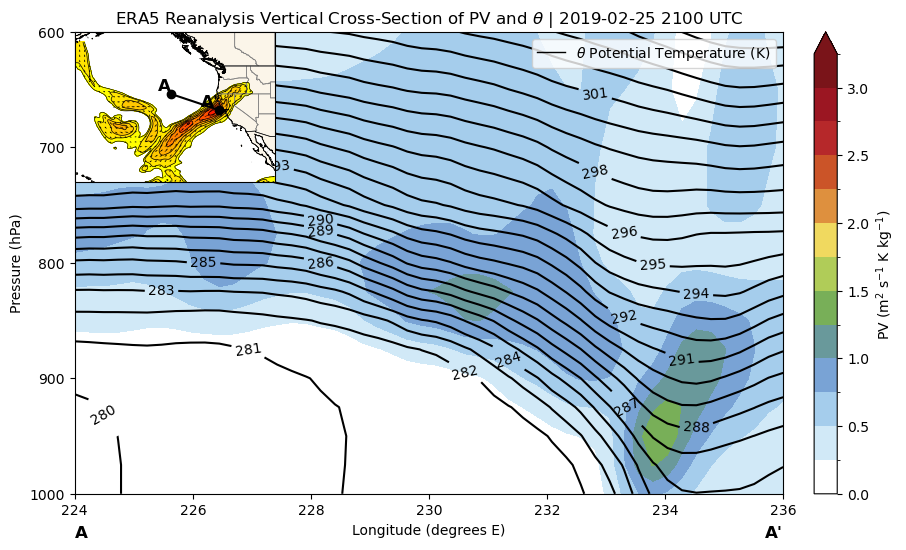

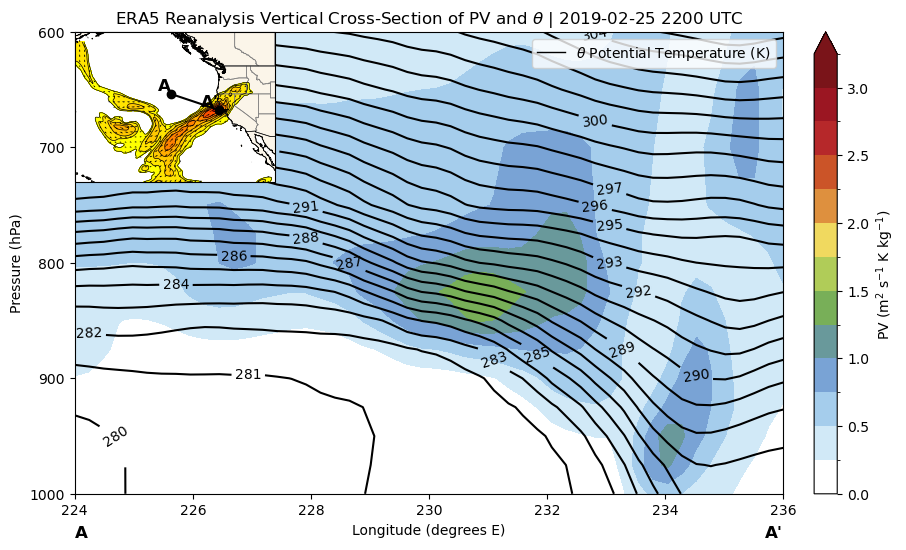

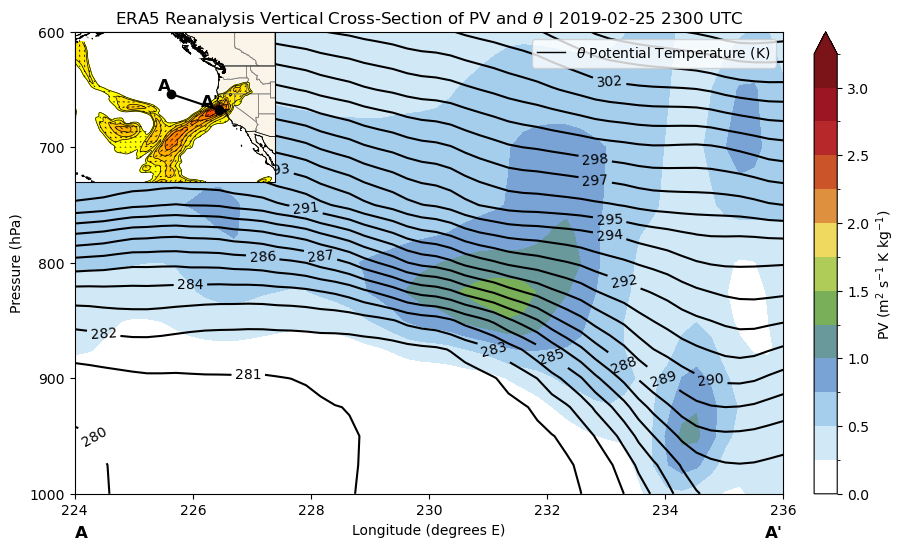

In [25]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200} #units: degrees North, degrees East
    start_point = (42.0, 360-136) #units: degrees North, degrees East
    end_point = (38.0, 360-124) #units: degrees North, degrees East
    g = 9.81 # units: m/s^2
    #theta_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g)
    #thetae_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g)
    #fgen_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g)
    updated_cross(start_point, end_point, ds_pl, ds_sfc, directions, g)